# Step 1-1 Data Analysis

train_3_df : train data which was split from test size = 9 last years

## Summary

### Lag correlation
By running lag correlations for the target (lags) and the features (lags), 

The minimum corr coef was 0.89 for the features for all 3 coutnries.

The max std is 0.43 for energy-co2 for the US, the strong corr coef and low variability show the reliability of the features. (+consistency)

* There were strong correlations between same time elements (co2_t - gdp_t and co2_t - energy_t).

This shows a synchronous relationship across the time.

* There were strong correlations between different time elements (co2_t - gdp_lags, co2_t - eneryg_lags, ...)

This shows that the lags have a predictive effect and used well for forecasting.

***
## Need to be discussed to add the info below
### R2 Score
* Energy - CO2

all r2_score > 0.79 and the avg is 0.9559 (explains 95.59% of CO2 variance). The feature (lags) is robust on forecasting CO2.

* GDP - CO2 

the std r2 score is 0.11691 and r2 score of lag4 on CO2 is 0.715 for the US (min). Though there is a moderate degradation with increase in time lag, the avg_r2_score for gdp is 0.912 which means this feature can explain well for CO2 variance.

### Granger Causality
* GDP - CO2:

China with lag 3 and India with lag 3 are significant. But it is not significant for the US.

* Energy - CO2:

China with lag 3 and India with lag 1 are significant. But not the US.

To test country-specific temporal changes between features and CO2 emissions, Granger causality has been tested. Both GDP and Energy demonstrated significant granger causality in China and India, while there was no significant granger causality in the US for both features.

In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import r2_score

import os
import warnings

warnings.filterwarnings("ignore")

In [113]:
# Config
TARGET_VARIABLES = 'co2'
CANDIDATE_FEATURES = ['gdp', 'primary_energy_consumption']
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]
SELECTED_COUNTRIES = ['United States', 'China', 'India']
MAX_LAGS = 4
TEST_SIZE = 9

In [98]:
def load_data(load_dir='data'):
    data_files = {
        'all_data_df': os.path.join(load_dir, 'all_data_df.csv'),
        'g20_df': os.path.join(load_dir, 'g20_df.csv'),
        'lag_df': os.path.join(load_dir, 'lag_df.csv'),
        'g20_lag_df': os.path.join(load_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(load_dir, 'lag_three_sel_1969_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [139]:
data = load_data()
g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]
lag_three_sel_1969_df = data['lag_three_sel_1969_df']
save_dir = 'data/01_01_results'
os.makedirs(save_dir, exist_ok=True)

Loaded all_data_df: (55529, 200)
Loaded g20_df: (3744, 200)
Loaded lag_df: (55529, 992)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)


In [140]:
# train_test_split
def tts_by_year(df, test_size=9):
    train_data = {}
    test_data = {}

    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')

        split_idx = len(country_data) - test_size
        train_data[country] = country_data.iloc[:split_idx]
        test_data[country] = country_data.iloc[split_idx:]

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [141]:
train_3_df, test_3_df = tts_by_year(lag_three_sel_1969_df, TEST_SIZE)
train_g20_df, test_g20_df = tts_by_year(g20_lag_1969_df, TEST_SIZE)

print(f"3 countries train shape: {train_3_df.shape}")
print(f"3 countries train years: {train_3_df['year'].min()} - {train_3_df['year'].max()}")
print(f"3 countriees test years: {test_3_df['year'].min()} - {test_3_df['year'].max()}")

3 countries train shape: (135, 992)
3 countries train years: 1969 - 2013
3 countriees test years: 2014 - 2022


### Lag correlation

In [103]:
# Lagged columns
def lagged_columns(df, feature, max_lags=4):
    cols = [feature]
    for lag in range(1, max_lags + 1):
        lag_col = f"{feature}_lag{lag}"
        if lag_col in df.columns:
            cols.append(lag_col)
    return cols

In [104]:
# Calculate lag corr
def calculate_lag_corr(df, target='co2', feature='gdp', max_lags=4):
    co2_cols = lagged_columns(df, target, max_lags)
    feature_cols = lagged_columns(df, feature, max_lags)
    
    all_cols = co2_cols + feature_cols
    corr_df = df[all_cols].corr()

    corr_matrix = corr_df.loc[co2_cols, feature_cols]

    return corr_matrix

In [105]:
# Calculate country corr
def calculate_country_corr(df, countries, target='co2', feature='gdp', max_lags=4):
    country_corr = {}
    
    for country in countries:
        country_data = df[df['country'] == country]
        corr_matrix = calculate_lag_corr(country_data, target, feature, max_lags)
        country_corr[country] = corr_matrix
    
    return country_corr

In [106]:
# Plot heatmap
def plot_lag_corr_heatmap(train_df, countries, target='co2', features=CANDIDATE_FEATURES, save_dir='data/01_01_results'):
    for feature in features:
        print(f"\nCorrelation between {target} vs{feature}")

        country_corr = calculate_country_corr(train_df, countries, target, feature)

        fig, axes = plt.subplots(1, 3, figsize=(16, 8))

        for idx, country in enumerate(countries):
            ax = axes[idx]
            corr_matrix = country_corr[country]
            sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0, vmin=-1, vmax=1, square=True,
                        linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
            ax.set_title(f'{country}', fontsize=12, fontweight='bold')
            ax.set_xlabel(f'{feature} (lags)', fontsize=10)
            ax.set_ylabel(f'{target} (lags)', fontsize=10)

        plt.suptitle(f'Lagged {target} vs Lagged {feature}', fontsize=14, fontweight='bold')
        plt.tight_layout()

        filename = f'lag_corr_co2_vs_{feature}_train.png'
        plt.savefig(os.path.join(save_dir, filename), dpi=150, bbox_inches='tight')

In [107]:
for feature in CANDIDATE_FEATURES:
    country_corr = calculate_country_corr(train_3_df, SELECTED_COUNTRIES, 'co2', feature)
    for country in SELECTED_COUNTRIES:
        print(f"\n{country.upper()}")
        print(country_corr[country].describe())


UNITED STATES
            gdp  gdp_lag1  gdp_lag2  gdp_lag3  gdp_lag4
count  5.000000  5.000000  5.000000  5.000000  5.000000
mean   0.914372  0.912619  0.908703  0.901891  0.893692
std    0.015985  0.020624  0.026930  0.031705  0.034715
min    0.890884  0.880203  0.868184  0.857021  0.845511
25%    0.905064  0.904106  0.894171  0.881920  0.872229
50%    0.921211  0.922637  0.922056  0.911786  0.901199
75%    0.927069  0.927971  0.929283  0.928557  0.919680
max    0.927632  0.928179  0.929823  0.930170  0.929840

CHINA
            gdp  gdp_lag1  gdp_lag2  gdp_lag3  gdp_lag4
count  5.000000  5.000000  5.000000  5.000000  5.000000
mean   0.994895  0.995415  0.995364  0.994636  0.993409
std    0.002302  0.001716  0.001102  0.001324  0.001512
min    0.991453  0.992655  0.993976  0.992624  0.991630
25%    0.993788  0.994938  0.994422  0.994126  0.992398
50%    0.995503  0.996212  0.995754  0.994932  0.993112
75%    0.996833  0.996237  0.996250  0.995489  0.994728
max    0.996896  0.997035 


Correlation between co2 vsgdp

Correlation between co2 vsprimary_energy_consumption


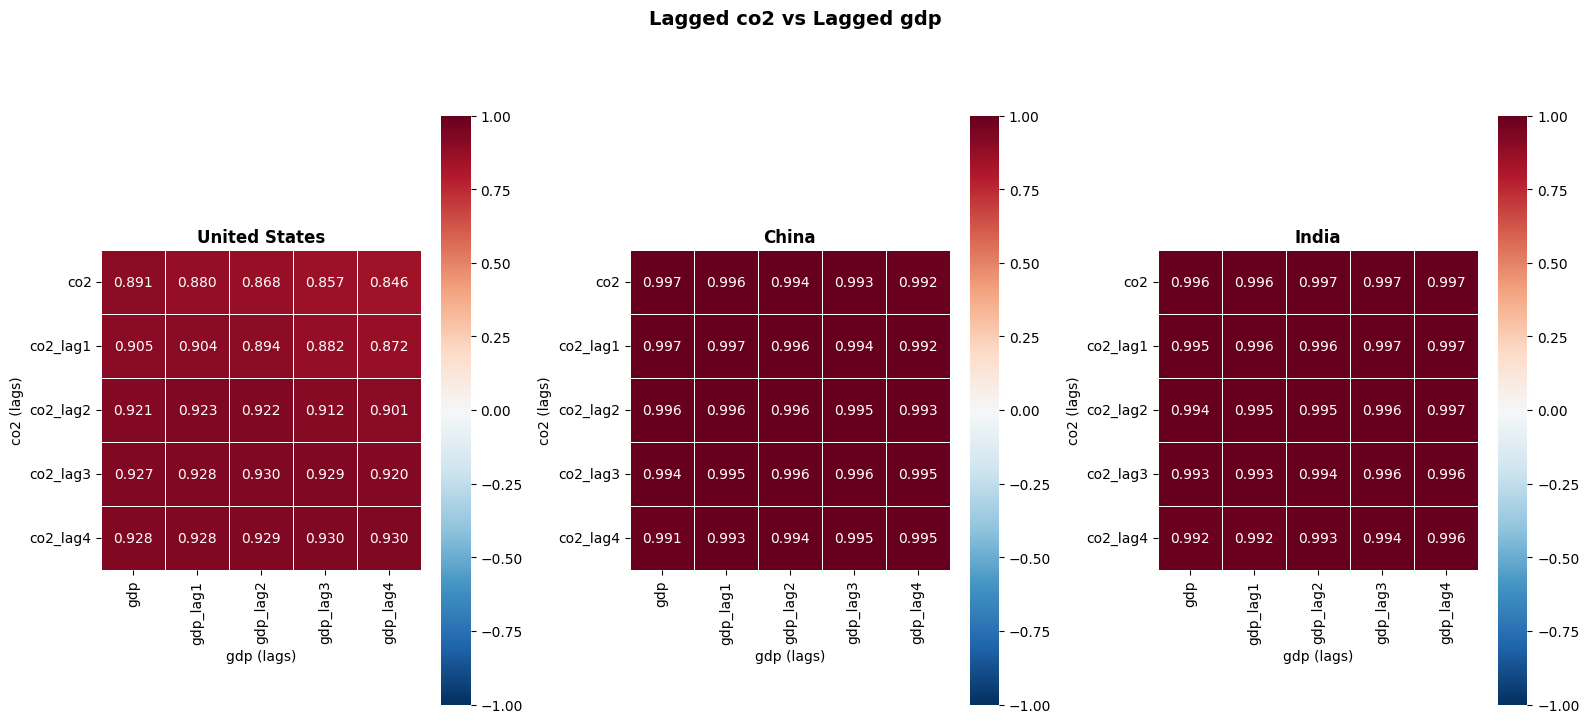

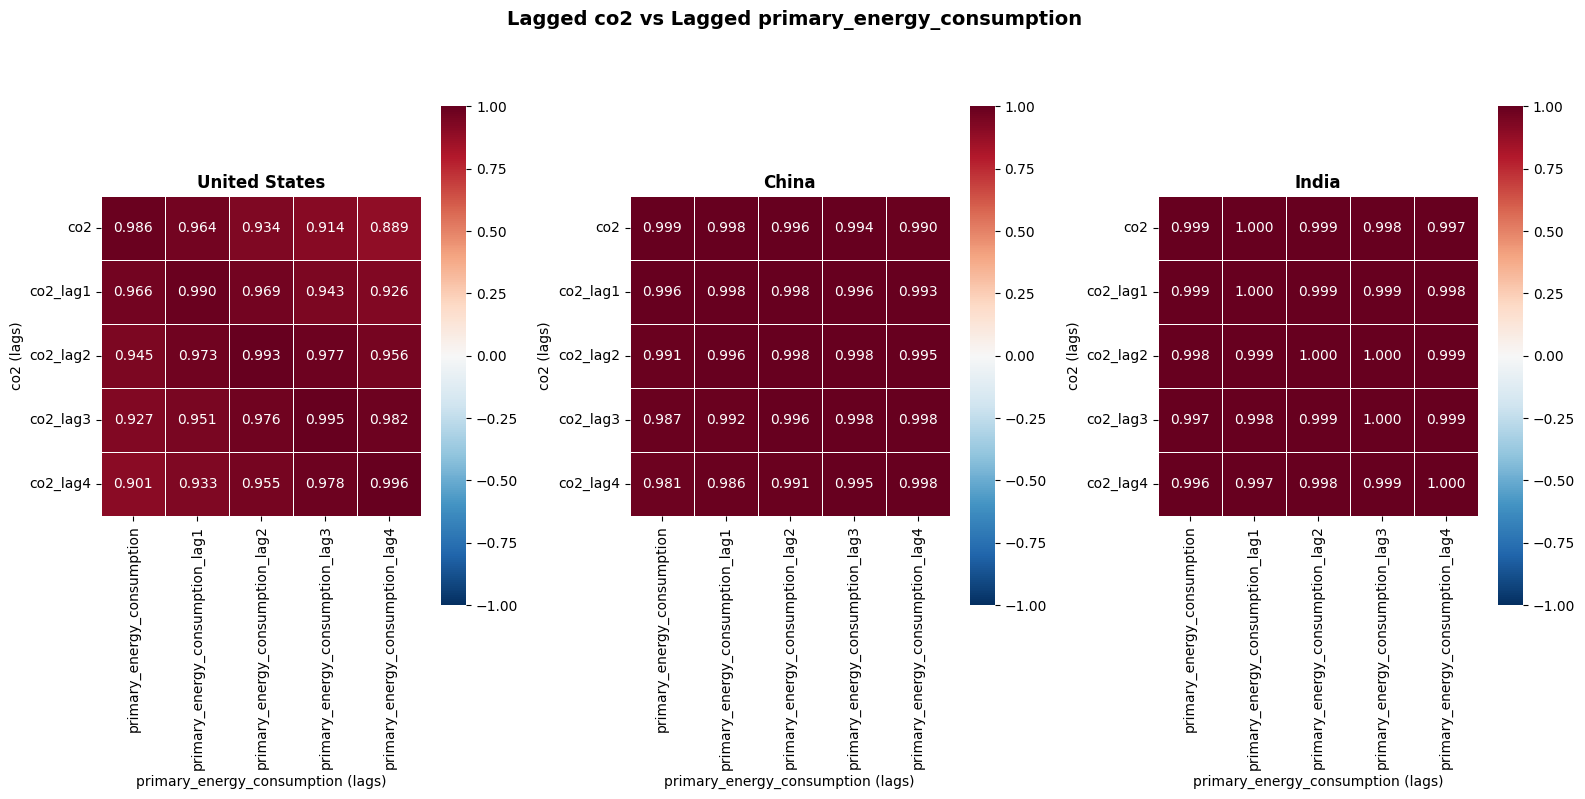

In [108]:
plot_lag_corr_heatmap(train_3_df, SELECTED_COUNTRIES, 'co2')

In [ ]:
# Combined correlation for co2 vs feature lags
def calculate_combined_country_corr(df, countries, target='co2', feature='gdp', max_lags=4):
    combined_corr = []
    
    for country in countries:
        country_data = df[df['country'] == country]
        
        feature_cols = [feature]
        for lag in range(1, max_lags + 1):
            lag_col = f"{feature}_lag{lag}"
            if lag_col in country_data.columns:
                feature_cols.append(lag_col)
        
        cols = [target] + feature_cols
        data = country_data[cols].dropna()
        
        # First row of correlations for co2
        corr_row = data.corr().loc[target, feature_cols].values
        combined_corr.append(corr_row)
    
    # DataFrame for the combined correlation
    col_names = [feature] + [f"{feature}_lag{i}" for i in range(1, max_lags + 1)]
    row_names = [f"{country}_co2" for country in countries]
    
    corr_df = pd.DataFrame(combined_corr, index=row_names, columns=col_names)
    
    return corr_df

In [171]:
# Plotting two heatmaps for each lagged features
def plot_combined_lag_corr_heatmap(train_df, countries, target='co2', features=CANDIDATE_FEATURES, save_dir='data/01_01_results'):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for idx, feature in enumerate(features):
        feature_name = 'energy' if feature == 'primary_energy_consumption' else feature
        
        print(f"\nCorrelation between {target} vs {feature_name}")
        combined_corr = calculate_combined_country_corr(train_df, countries, target, feature)
        
        if feature == 'primary_energy_consumption':
            combined_corr.columns = ['energy'] + [f"energy_lag{i}" for i in range(1, len(combined_corr.columns))]
        
        # Plot
        ax = axes[idx]
        sns.heatmap(combined_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
                    vmin=-1, vmax=1, square=False, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
        ax.set_title(f'CO2 vs Lagged {feature_name.title().upper()}', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{feature_name.upper()} (lags)', fontsize=10, fontweight='bold')
        ax.set_ylabel('CO2 by Country', fontsize=10, fontweight='bold', rotation=45)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
    
    plt.suptitle('CO2 vs Lagged Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    filename = 'corr_co2_vs_lagged_features_combined.png'
    plt.savefig(os.path.join(save_dir, filename), dpi=150, bbox_inches='tight')
    plt.show()


Correlation between co2 vs gdp

Correlation between co2 vs energy


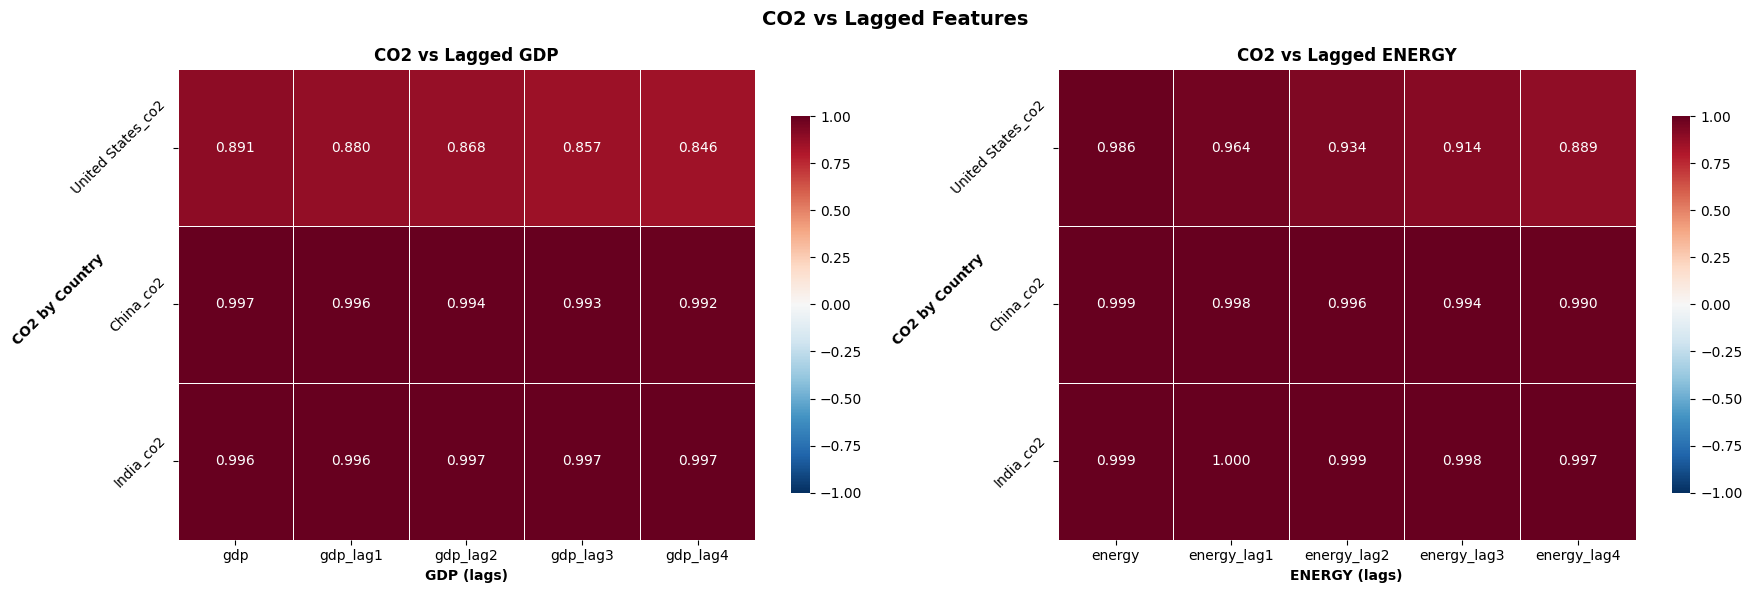

In [172]:
plot_combined_lag_corr_heatmap(train_3_df, SELECTED_COUNTRIES, 'co2')

This scatter plot can back up why the corr coefs are a bit weaker on different lags on the US

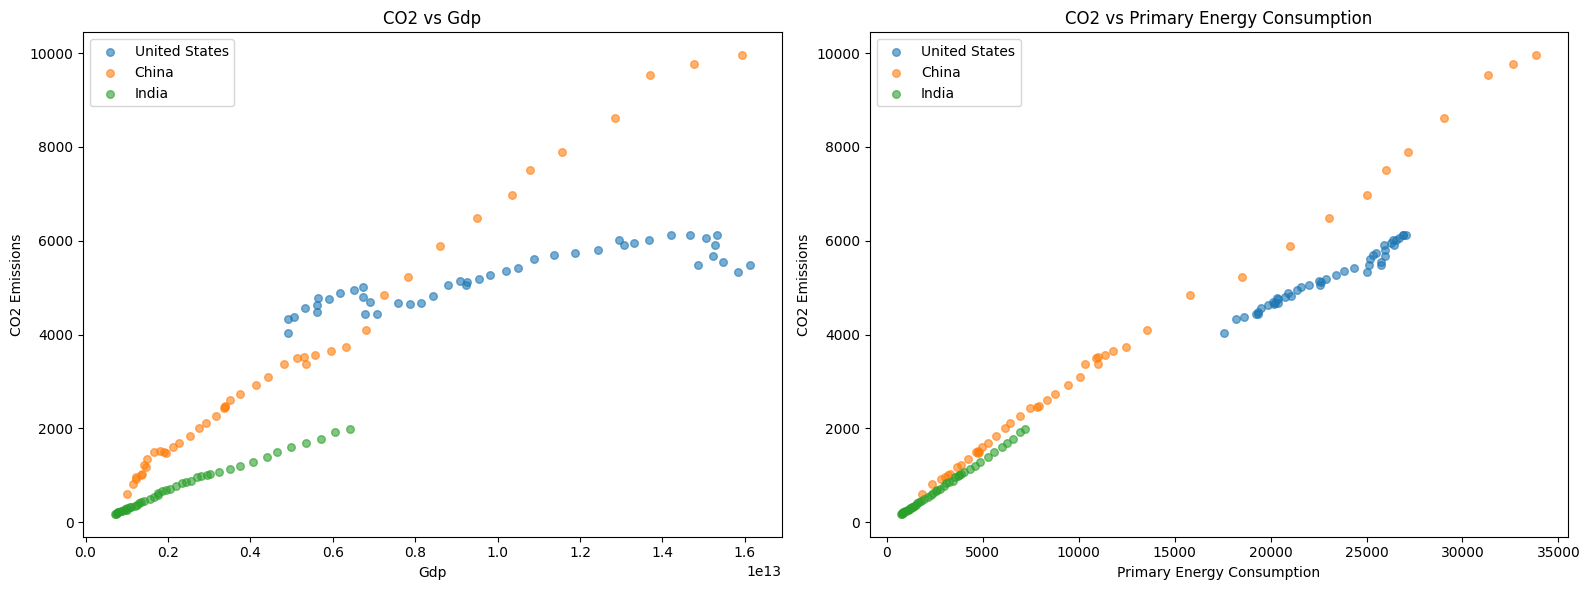

In [110]:
# Scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, feature in enumerate(CANDIDATE_FEATURES):
    ax = axes[idx]
    
    for country in ['United States', 'China', 'India']:
        country_data = train_3_df[train_3_df['country'] == country]
        data = country_data[[TARGET_VARIABLES, feature]].dropna()
        
        ax.scatter(data[feature], data[TARGET_VARIABLES], alpha=0.6, label=country, s=30)
    
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('CO2 Emissions')
    ax.set_title(f'CO2 vs {feature.replace("_", " ").title()}')
    ax.legend()
    plt.tight_layout()


### R2

In [121]:
# Variance (R^2)
def calculate_r2_scores_lags(df, target='co2', features=CANDIDATE_FEATURES, max_lags=MAX_LAGS):
    r2_results = []

    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        
        for feature in features:
            for lag in range(max_lags + 1):
                if lag == 0:
                    col = feature
                else:
                    col = f"{feature}_lag{lag}"
                
                if col not in country_data.columns:
                    continue

                data = country_data[[target, col]].dropna()
                
                if len(data) > 10:
                    X = data[[col]].values
                    y = data[target].values
                    
                    # Fit model
                    model = LinearRegression()
                    model.fit(X, y)
                    r2 = r2_score(y, model.predict(X))
                    
                    r2_results.append({
                        'country': country,
                        'feature': feature,
                        'lag': lag,
                        'r2_score': r2
                    })
    
    return pd.DataFrame(r2_results)

In [123]:
# R2 score
r2_results = calculate_r2_scores_lags(train_3_df, 'co2', CANDIDATE_FEATURES)
for country in SELECTED_COUNTRIES:
    print(f"\n{country}")
    country_r2 = r2_results[r2_results['country'] == country]

    for feature in CANDIDATE_FEATURES:
        feature_r2 = country_r2[country_r2['feature'] == feature]
        print(f"\n{feature}")
        print(feature_r2[['lag', 'r2_score']].to_string(index=False))


United States

gdp
 lag  r2_score
   0  0.793674
   1  0.774758
   2  0.753744
   3  0.734486
   4  0.714888

primary_energy_consumption
 lag  r2_score
   0  0.973158
   1  0.929682
   2  0.872220
   3  0.835043
   4  0.789641

China

gdp
 lag  r2_score
   0  0.993802
   1  0.992487
   2  0.988875
   3  0.985302
   4  0.983330

primary_energy_consumption
 lag  r2_score
   0  0.997044
   1  0.996510
   2  0.992345
   3  0.987078
   4  0.979507

India

gdp
 lag  r2_score
   0  0.992178
   1  0.992907
   2  0.993265
   3  0.993542
   4  0.993359

primary_energy_consumption
 lag  r2_score
   0  0.998952
   1  0.999007
   2  0.998110
   3  0.996318
   4  0.994244


In [124]:
print(r2_results.groupby('feature')['r2_score'].describe())

                            count      mean       std       min       25%  \
feature                                                                     
gdp                          15.0  0.912040  0.116691  0.714888  0.784216   
primary_energy_consumption   15.0  0.955924  0.068156  0.789641  0.951420   

                                 50%       75%       max  
feature                                                   
gdp                         0.988875  0.993086  0.993802  
primary_energy_consumption  0.992345  0.996777  0.999007  


In [150]:
def plot_r2_scores(r2_results, save_dir='data/01_01_results'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = {'United States': 'blue', 'China': 'red', 'India': 'green'}
    
    for idx, feature in enumerate(CANDIDATE_FEATURES):
        ax = axes[idx]
        feature_data = r2_results[r2_results['feature'] == feature]
        
        x = np.arange(5)  # 5 lag periods (0-4)
        width = 0.25
        
        for i, country in enumerate(SELECTED_COUNTRIES):
            country_data = feature_data[feature_data['country'] == country].sort_values('lag')
            r2_values = country_data['r2_score'].values
            
            bars = ax.bar(x + i*width, r2_values, width, 
                         label=country, color=colors[country], 
                         alpha=0.8, edgecolor='black', linewidth=0.5)
            
            for bar, val in zip(bars, r2_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        
        ax.set_xlabel('Lag Period', fontsize=12, fontweight='bold')
        ax.set_ylabel('R2 Score', fontsize=12, fontweight='bold')
        ax.set_title(f'{feature.replace("_", " ").title()}', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x + width)
        ax.set_xticklabels(['t', 't-1', 't-2', 't-3', 't-4'])
        ax.legend(loc='best', fontsize=10)
        ax.set_ylim([0.65, 1.05])
        
        ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax.text(0.1, 0.91, 'R²=0.9', fontsize=9, color='gray')
    
    plt.suptitle('R2 Scores: GDP and Energy for CO2 Emissions', fontsize=16, fontweight='bold')
    plt.tight_layout()

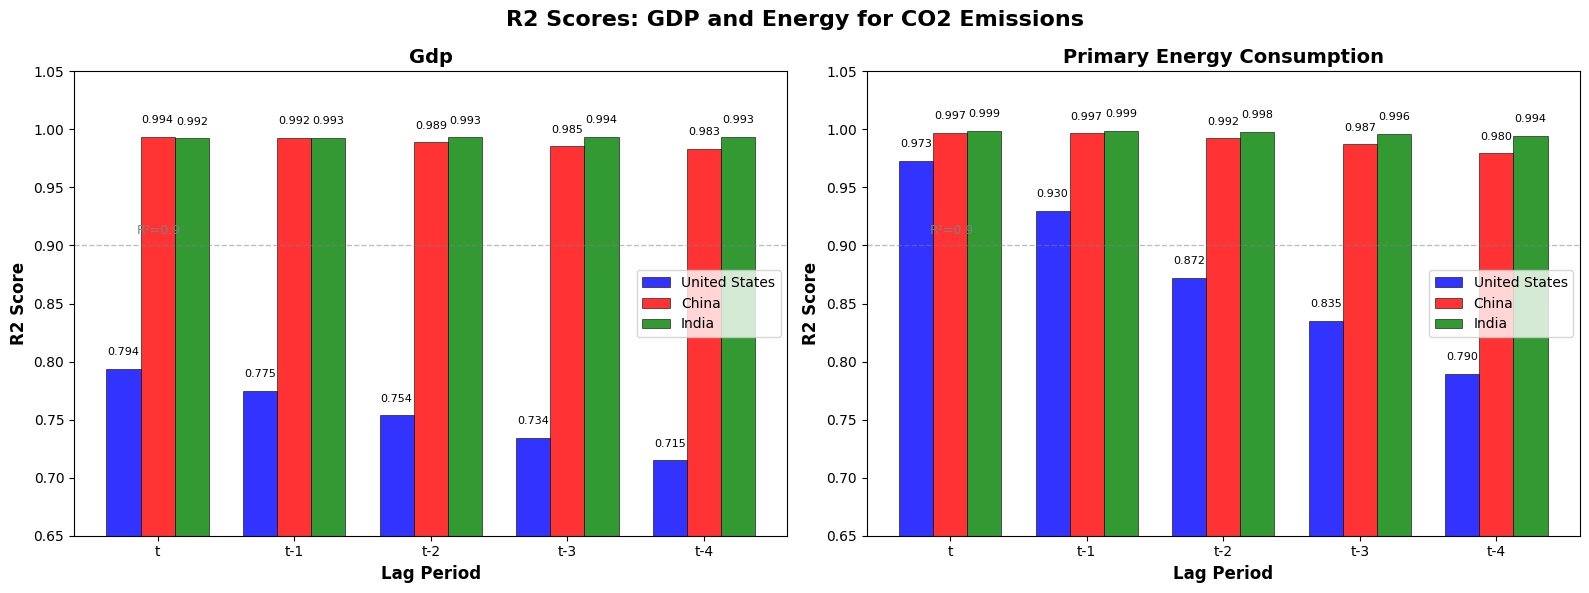

In [151]:
plot_r2_scores(r2_results, save_dir)

For Energy-CO2, all r2_score > 0.79 and the avg is 0.9559 (explains 95.59% of CO2 variance). The feature (lags) is robus on forecasting CO2.

For GDP-CO2, the std r2 score is 0.11691 and r2 score of lag4 on CO2 is 0.715 for the US. Though there is a moderate degradation with increase in time lag, the avg_r2_score for gdp is 0.912 which means this feature can explain well for CO2 variance.

### Granger Causality

In [128]:
# Granger causality (sig level = 0.05)
# This is used to test if the feature's history can predict the target well.

def granger(df, target, features, max_lags=4):
    granger_results = []

    for country in df['country'].unique():
        country_data = df[df['country'] == country]

        for feature in features:
            data = country_data[[target, feature]].dropna()

            if len(data) > max_lags + 10:
                try:
                    granger_cuz = grangercausalitytests(data, max_lags, verbose=False)

                    for lag in range(1, max_lags):
                        p_val = granger_cuz[lag][0]['ssr_ftest'][1]
                        granger_results.append({
                            'country': country,
                            'feature': feature,
                            'lag': lag,
                            'p_value': p_val,
                            'significant': p_val < 0.05
                        })
                except:
                    continue
    
    return pd.DataFrame(granger_results)

In [129]:
granger_results = granger(train_3_df, TARGET_VARIABLES, CANDIDATE_FEATURES)
print(granger_results.groupby('feature')['significant'].mean())
print("\nBest lag:")
print(granger_results.loc[granger_results.groupby(['country', 'feature'])['p_value'].idxmin()])

feature
gdp                           0.555556
primary_energy_consumption    0.666667
Name: significant, dtype: float64

Best lag:
          country                     feature  lag   p_value  significant
2           China                         gdp    3  0.002731         True
5           China  primary_energy_consumption    3  0.000007         True
8           India                         gdp    3  0.004127         True
9           India  primary_energy_consumption    1  0.000016         True
13  United States                         gdp    2  0.610894        False
16  United States  primary_energy_consumption    2  0.248113        False


In [148]:
def plot_granger_results(granger_results, save_dir='data/01_01_results'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for idx, feature in enumerate(CANDIDATE_FEATURES):
        ax = axes[idx]
        feature_data = granger_results[granger_results['feature'] == feature]
        
        countries = SELECTED_COUNTRIES
        best_lags = []
        best_pvals = []
        colors_list = []
        
        for country in countries:
            country_data = feature_data[feature_data['country'] == country]
            if len(country_data) > 0:
                best_row = country_data.loc[country_data['p_value'].idxmin()]
                best_lags.append(f"lag {best_row['lag']}")
                best_pvals.append(best_row['p_value'])
                colors_list.append('green' if best_row['significant'] else 'red')
            else:
                best_lags.append('N/A')
                best_pvals.append(1.0)
                colors_list.append('gray')
        
        x_pos = np.arange(len(countries))
        bars = ax.bar(x_pos, best_pvals, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax.axhline(y=0.05, color='black', linestyle='--', linewidth=2, label='p=0.05 (significance threshold)')
        
        for i, (bar, pval, lag) in enumerate(zip(bars, best_pvals, best_lags)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'p={pval:.3f}\n{lag}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Country', fontsize=12, fontweight='bold')
        ax.set_ylabel('P-value (lower = stronger causality)', fontsize=12, fontweight='bold')
        ax.set_title(f'{feature.replace("_", " ").title()}', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(countries, fontsize=11)
        ax.set_ylim([0, max(best_pvals) * 1.2])
        ax.legend(loc='upper right', fontsize=9)
    
    plt.suptitle('Granger Causality Test: Best Lag P-values for Each Country', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

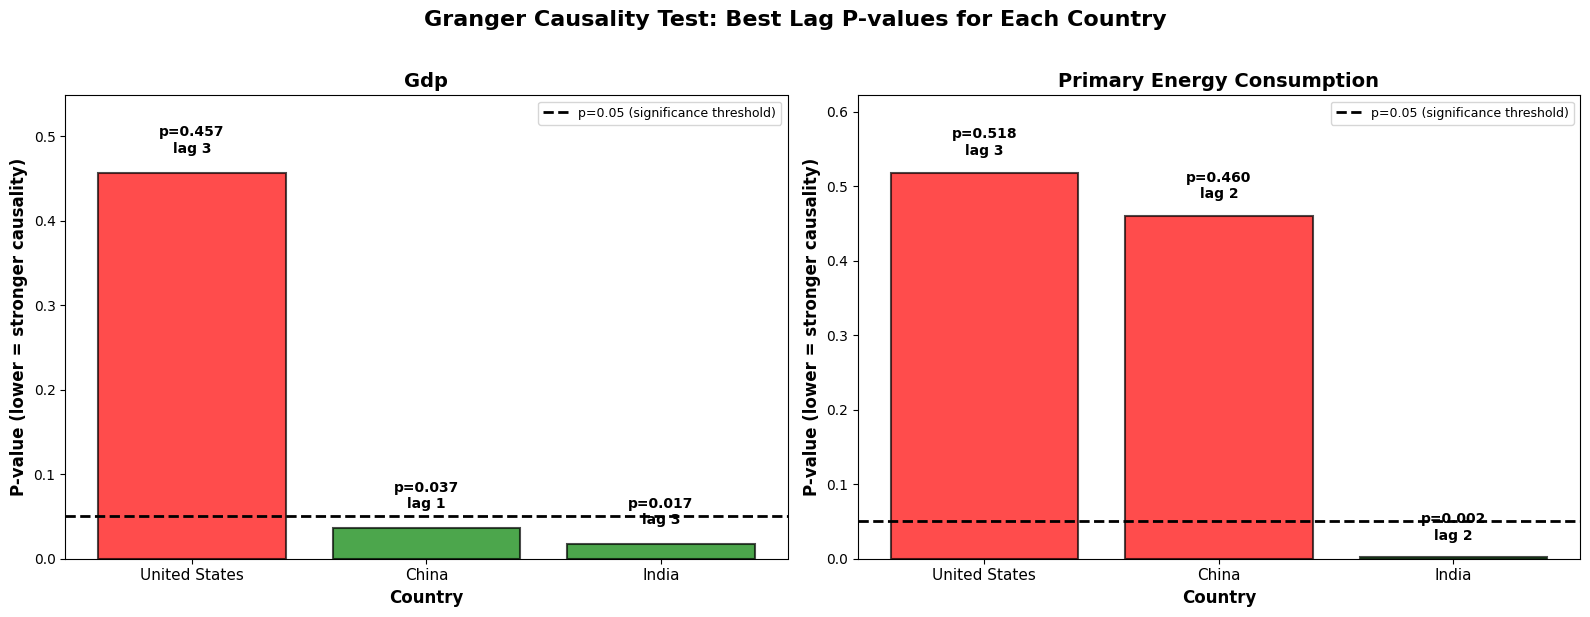

In [145]:
plot_granger_results(granger_results, save_dir)

* GDP - CO2:

China with lag 3 and India with lag 3 are significant. But it is not significant for the US.

* Energy - CO2:

China with lag 3 and India with lag 1 are significant. But not the US.

To test country-specific temporal changes between features and CO2 emissions, Granger causality has been tested. Both GDP and Energy demonstrated significant granger causality in China and India, while there was no significant granger causality in the US for both features.

### Country-Country Correlation on CO2

In [ ]:
def get_numerical_features(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = ['year']
    features = [col for col in numerical_cols if col not in exclude_cols and '_lag' not in col]
    return features

In [ ]:
# Country-country correlation
def calculate_country_correlation(df, target, countries=None):
    if countries is not None:
        df = df[df['country'].isin(countries)].copy()

    pivot_df = df.pivot(index='year', columns='country', values=target)
    corr_df = pivot_df.corr()

    return corr_df

In [ ]:
# Plot heatmap
def plot_heatmap(corr_df, title, filename, save_dir='data/01_01_results'):
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0, square=True, linewidths=0.5, cbar_kws={"shrink":0.8})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, filename), dpi=150, bbox_inches='tight')

### Co2-Co2 Correlations

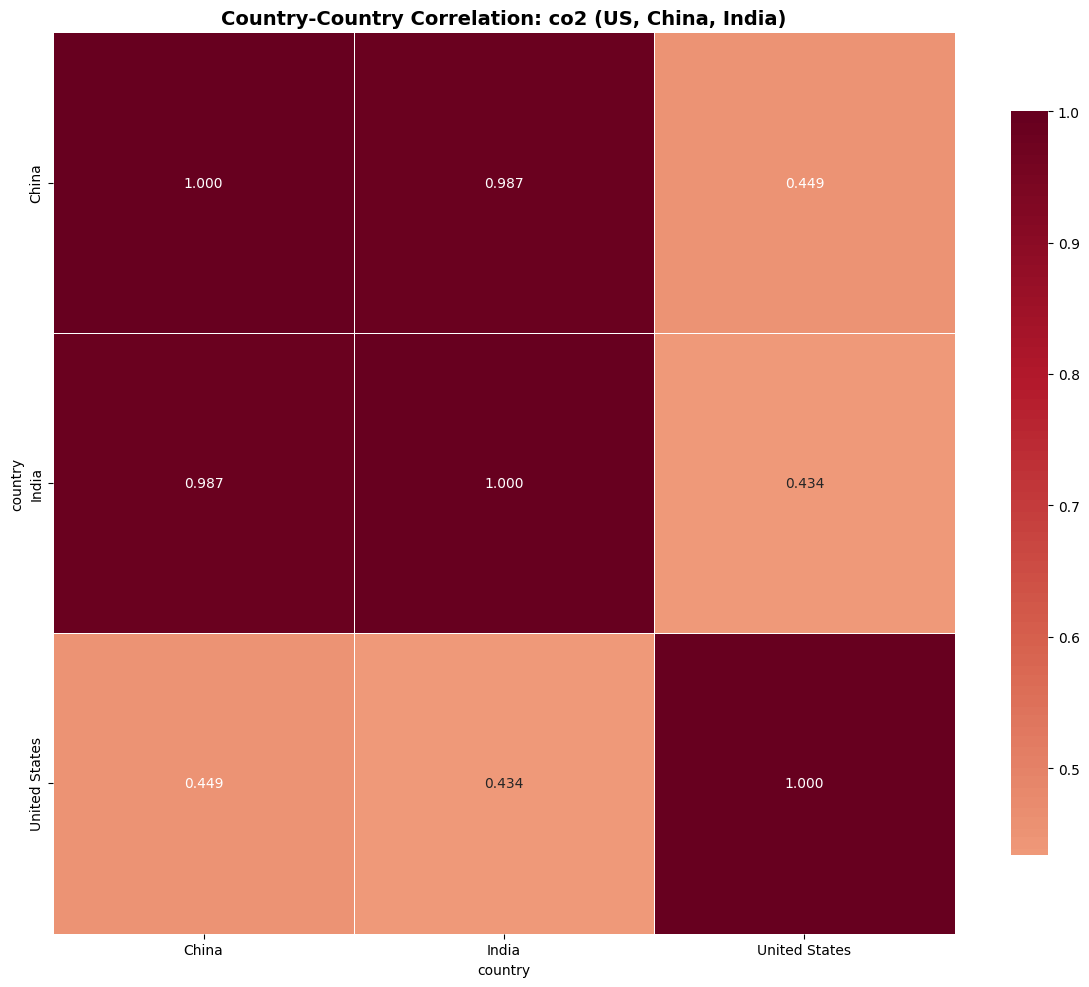

In [ ]:
# CC correlation for target variables

"""# G20
country_corr_g20 = calculate_country_correlation(g20_lag_df, TARGET_VARIABLES, G20_COUNTRIES)
plot_heatmap(country_corr_g20, f'Country-Country Correlation: {TARGET_VARIABLES} (G20)',
                f'country_correlation_{TARGET_VARIABLES}_g20.png')
country_corr_g20.to_csv(os.path.join(save_dir, f'country_correlation_{TARGET_VARIABLES}_g20.csv'))"""

# 3 countries
country_corr_3 = calculate_country_correlation(lag_three_sel_1969_df, TARGET_VARIABLES, SELECTED_COUNTRIES)
plot_heatmap(country_corr_3, f'Country-Country Correlation: {TARGET_VARIABLES} (US, China, India)',
                f'country_correlation_{TARGET_VARIABLES}_3.png')
country_corr_3.to_csv(os.path.join(save_dir, f'country_correlation_{TARGET_VARIABLES}_3.csv'))

After the comparison among the three selected countries (US, China, India), China and India tend to be more correlated for all three targets rather than the United States.